# Emotion Detection CNN Project

## Environment Setup

### Import the Libraries

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics
import joblib
import pandas as pd

# --- Constants and Parameters ---

# Define the size to which all images will be resized
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 32 # Number of images to process in each batch

# Define the paths to your training and test folders
base_dir = "Emotions Dataset/Emotions Dataset"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


## Data Loading and Preparation

In [28]:
# --- Training Data Loading ---
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    color_mode='grayscale',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

# --- Test Data Loading ---
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    color_mode='grayscale',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

# Get the class names
class_names = train_dataset.class_names
print("Clases encontradas:", class_names)
num_classes = len(class_names)

# --- Optimize dataset performance ---
# .cache() keeps data in memory to improve speed
# .prefetch() overlaps data preprocessing and model execution
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.
Clases encontradas: ['angry', 'happy', 'sad']


## Data Analysis and Visualization

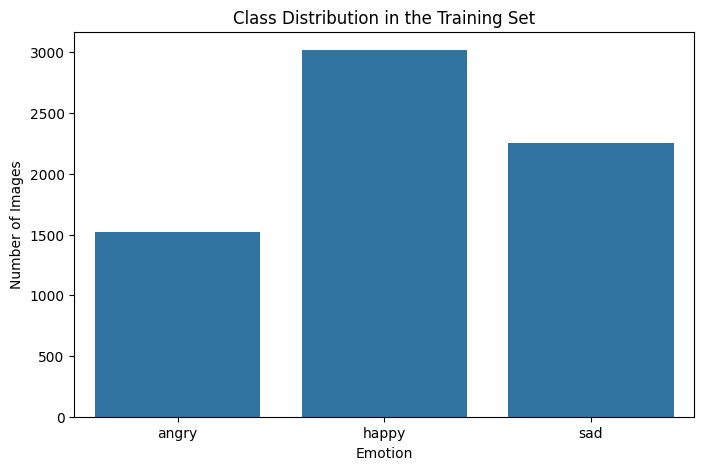

In [29]:
# Count images in each training subdirectory
train_counts = {}
for emotion in class_names:
    emotion_dir = os.path.join(train_dir, emotion)
    train_counts[emotion] = len(os.listdir(emotion_dir))

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Class Distribution in the Training Set')
plt.ylabel('Number of Images')
plt.xlabel('Emotion')
plt.show()

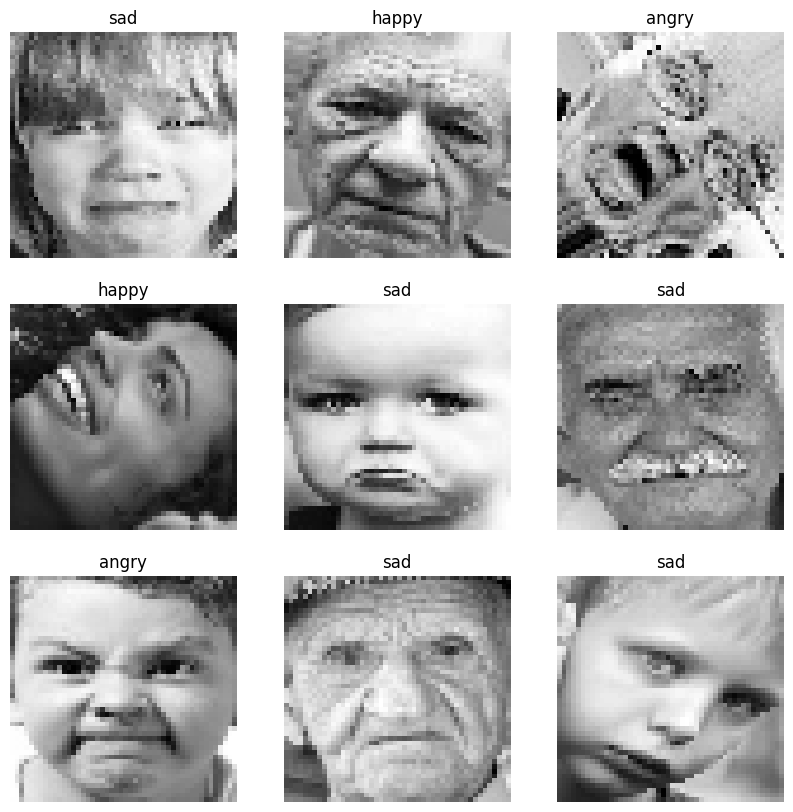

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Image Augmentation

In [31]:
# --- Data Augmentation Layer ---
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\nefth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Building the 3 CNN Models

Model 1: Basic CNN

In [32]:
model_1 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

Model 2: CNN with Dropout

In [33]:
model_2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

Model 3: Deep CNN with Normalization

In [34]:
model_3 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

## Model Compilation and Training


--- Training Model 1 (Basic) ---
Epoch 1/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7887 - loss: 0.5222 - val_accuracy: 0.7520 - val_loss: 0.6185
Epoch 2/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7971 - loss: 0.5011 - val_accuracy: 0.7713 - val_loss: 0.5756
Epoch 3/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8043 - loss: 0.4939 - val_accuracy: 0.7739 - val_loss: 0.5594
Epoch 4/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7986 - loss: 0.4867 - val_accuracy: 0.7788 - val_loss: 0.5844
Epoch 5/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8038 - loss: 0.4790 - val_accuracy: 0.7704 - val_loss: 0.5717
Epoch 6/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8055 - loss: 0.4734 - val_accuracy: 0.7717 - val_loss: 0.6033
Epoch 7/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8135 - loss: 0.4665 - val_accuracy: 0.7682 - val_loss: 0.5860
Epoch 8/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy

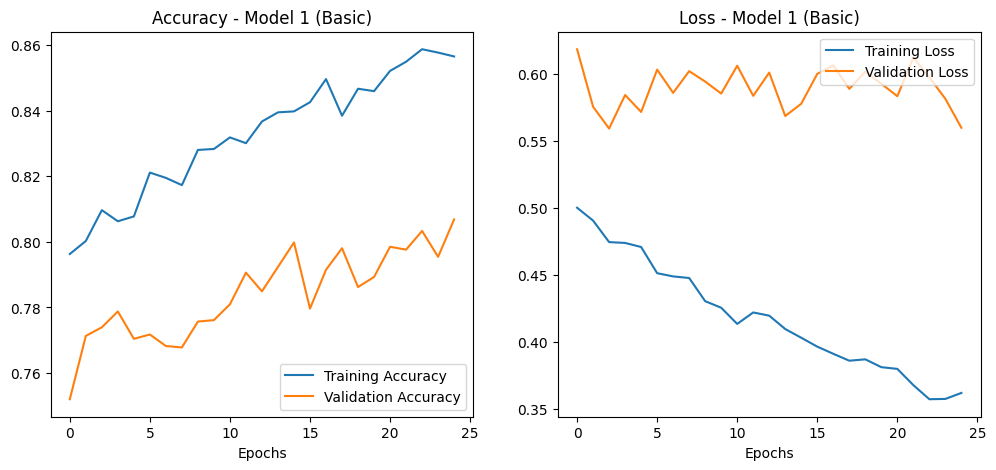


--- Training Model 2 (with Dropout) ---
Epoch 1/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.4358 - loss: 1.0767 - val_accuracy: 0.5048 - val_loss: 1.0098
Epoch 2/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5094 - loss: 1.0040 - val_accuracy: 0.5180 - val_loss: 0.9728
Epoch 3/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5418 - loss: 0.9665 - val_accuracy: 0.5149 - val_loss: 0.9738
Epoch 4/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5563 - loss: 0.9423 - val_accuracy: 0.5680 - val_loss: 0.9291
Epoch 5/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5800 - loss: 0.9286 - val_accuracy: 0.5939 - val_loss: 0.9050
Epoch 6/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5916 - loss: 0.9041 - val_accuracy: 0.6203 - val_loss: 0.8414
Epoch 7/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5956 - loss: 0.8746 - val_accuracy: 0.6212 - val_loss: 0.8382
Epoch 8/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - a

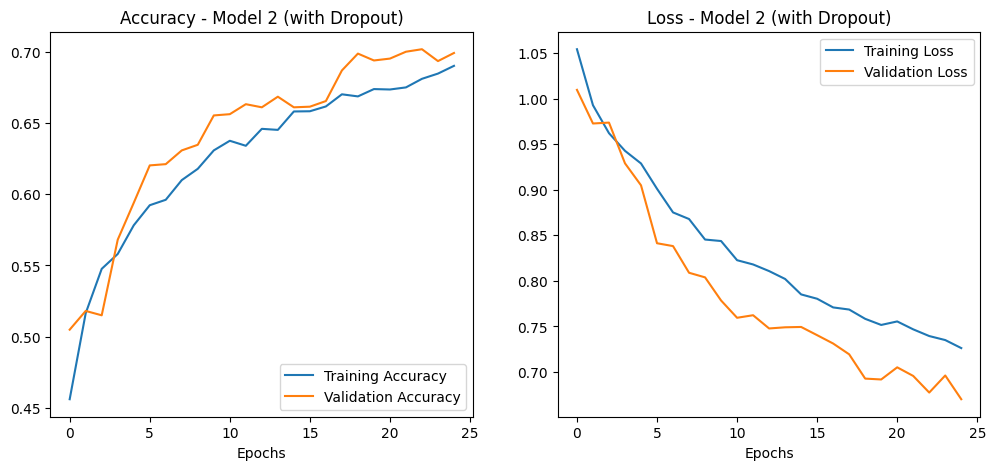


--- Training Model 3 (Deep) ---
Epoch 1/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 25s 100ms/step - accuracy: 0.4239 - loss: 1.4849 - val_accuracy: 0.4416 - val_loss: 2.5119
Epoch 2/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5060 - loss: 1.0930 - val_accuracy: 0.3428 - val_loss: 4.7155
Epoch 3/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5604 - loss: 0.9797 - val_accuracy: 0.6045 - val_loss: 0.9230
Epoch 4/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5820 - loss: 0.9180 - val_accuracy: 0.6409 - val_loss: 0.8087
Epoch 5/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6179 - loss: 0.8502 - val_accuracy: 0.6554 - val_loss: 0.8009
Epoch 6/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6386 - loss: 0.8194 - val_accuracy: 0.6255 - val_loss: 0.8283
Epoch 7/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6559 - loss: 0.7816 - val_accuracy: 0.6598 - val_loss: 0.7929
Epoch 8/25
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accura

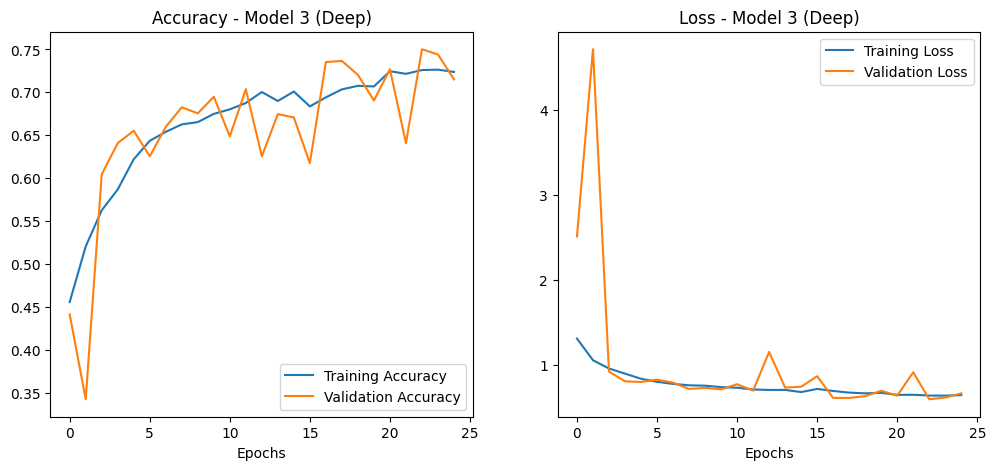

In [37]:
# --- Function to compile and train a model ---
def train_and_evaluate_model(model, model_name):
    print(f"\n--- Training {model_name} ---")
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    epochs = 25
    history = model.fit(
      train_dataset,
      validation_data=test_dataset,
      epochs=epochs
    )
    return history

# --- Function to visualize the results ---
def plot_history(history, model_name):
    metrics = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics.index, metrics['accuracy'], label='Training Accuracy')
    plt.plot(metrics.index, metrics['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Accuracy - {model_name}')
    plt.xlabel('Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics.index, metrics['loss'], label='Training Loss')
    plt.plot(metrics.index, metrics['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Loss - {model_name}')
    plt.xlabel('Epochs')
    
    plt.show()

# --- Train and visualize each model ---
history_1 = train_and_evaluate_model(model_1, "Model 1 (Basic)")
plot_history(history_1, "Model 1 (Basic)")

history_2 = train_and_evaluate_model(model_2, "Model 2 (with Dropout)")
plot_history(history_2, "Model 2 (with Dropout)")

history_3 = train_and_evaluate_model(model_3, "Model 3 (Deep)")
plot_history(history_3, "Model 3 (Deep)")

## Model Evaluation and Comparison

In [ ]:
# --- Final evaluation on the test set ---
print("\n--- Final Evaluation ---")
loss1, acc1 = model_1.evaluate(test_dataset)
print(f"Model 1 - Test Accuracy: {acc1:.2f}")

loss2, acc2 = model_2.evaluate(test_dataset)
print(f"Model 2 - Test Accuracy: {acc2:.2f}")

loss3, acc3 = model_3.evaluate(test_dataset)
print(f"Model 3 - Test Accuracy: {acc3:.2f}")

# We'll save the best model
best_model = model_3


--- Evaluación Final ---
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7526 - loss: 0.6071
Modelo 1 - Precisión en prueba: 0.76
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6841 - loss: 0.6989
Modelo 2 - Precisión en prueba: 0.69
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7560 - loss: 0.5713


Modelo 3 - Precisión en prueba: 0.75

¡Mejor modelo (Modelo 3) guardado como 'emotion_classifier_model.h5'!


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Classification Report (Best Model) ---
              precision    recall  f1-score   support

       angry       0.63      0.73      0.68       515
       happy       0.82      0.85      0.83      1006
         sad       0.77      0.64      0.70       757

    accuracy                           0.75      2278
   macro avg       0.74      0.74      0.74      2278
weighted avg       0.76      0.75      0.75      2278


--- Confusion Matrix (Best Model) ---


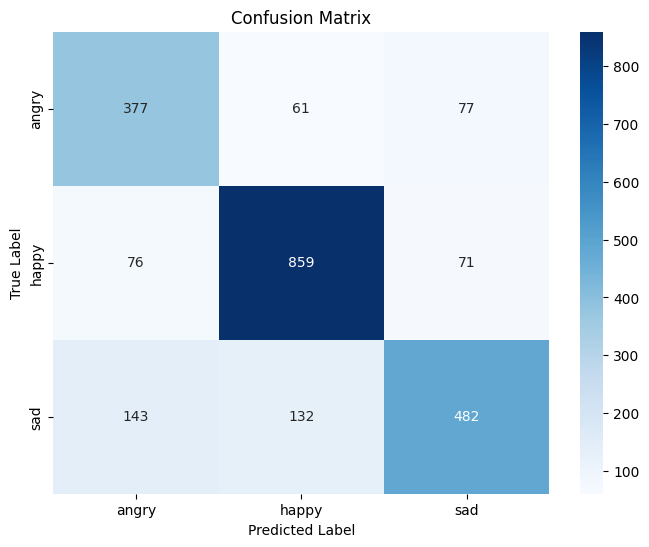

In [41]:
# Get true labels and predictions for the test set
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
predictions_prob = best_model.predict(test_dataset)
y_pred = np.argmax(predictions_prob, axis=1)

# Classification Report
print("\n--- Classification Report (Best Model) ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
print("\n--- Confusion Matrix (Best Model) ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [42]:
# Save the best model
joblib.dump(best_model, "emotion_classifier_model.pkl")
print("\nBest model saved as 'emotion_classifier_model.pkl'!")

# Save the class names (useful for deployment)
joblib.dump(class_names, "class_names.pkl")
print("Class names saved as 'class_names.pkl'!")


Best model saved as 'emotion_classifier_model.pkl'!
Class names saved as 'class_names.pkl'!


c:\Users\nefth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step

--- Making a prediction ---
The image is of the class: happy
The model's prediction is: happy
Prediction confidence: 57.60%


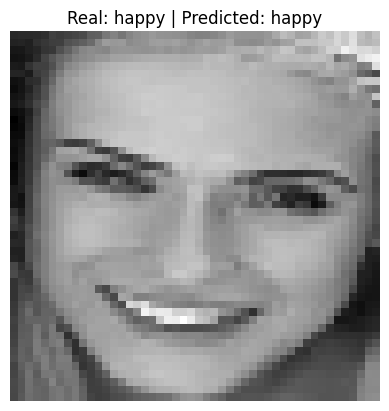

In [44]:
# --- Load the model and class names ---
loaded_model_pkl = joblib.load("emotion_classifier_model.pkl")
loaded_class_names = joblib.load("class_names.pkl")

# --- Take a test image ---
image_batch, label_batch = next(iter(test_dataset))
first_image = image_batch[0]
true_label = label_batch[0]

# The model expects a batch, so we add a dimension
img_array = tf.expand_dims(first_image, 0) 

# --- Make the prediction ---
predictions = loaded_model_pkl.predict(img_array)
score = tf.nn.softmax(predictions[0])
predicted_class = loaded_class_names[np.argmax(score)]

# --- Print and visualize results ---
print("\n--- Making a prediction ---")
print(f"The image is of the class: {loaded_class_names[true_label]}")
print(f"The model's prediction is: {predicted_class}")
print(f"Prediction confidence: {100 * np.max(score):.2f}%")

plt.imshow(first_image.numpy().astype("uint8"), cmap='gray')
plt.title(f"Real: {loaded_class_names[true_label]} | Predicted: {predicted_class}")
plt.axis("off")
plt.show()